In [3]:
import os
import gzip
import time
try:
    import cPickle as pickle  # python2
except ModuleNotFoundError:
    import pickle # python3
    
import numpy as np
import tensorflow as tf
from tensorflow.python.client import device_lib

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc 
# use font and figure size for latex
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
textwidth_tex_a4 = 6.27
fig_factor = 0.9
golden_ratio = 1.6180339887
rc('figure', figsize=(fig_factor*textwidth_tex_a4, fig_factor*textwidth_tex_a4/golden_ratio))


/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Implementing LeNet in Tensorflow

In [4]:
def mnist(datasets_dir='./data'):
    if not os.path.exists(datasets_dir):
        os.mkdir(datasets_dir)
    data_file = os.path.join(datasets_dir, 'mnist.pkl.gz')
    if not os.path.exists(data_file):
        print('... downloading MNIST from the web')
        try:
            import urllib
            urllib.urlretrieve('http://google.com')
        except AttributeError:
            import urllib.request as urllib
        url = 'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
        urllib.urlretrieve(url, data_file)

    print('... loading data')
    # Load the dataset
    f = gzip.open(data_file, 'rb')
    try:
        train_set, valid_set, test_set = pickle.load(f, encoding="latin1")
    except TypeError:
        train_set, valid_set, test_set = pickle.load(f)
    f.close()

    test_x, test_y = test_set
    test_x = test_x.astype('float32')
    test_x = test_x.astype('float32').reshape(test_x.shape[0], 1, 28, 28)
    test_y = test_y.astype('int32')
    valid_x, valid_y = valid_set
    valid_x = valid_x.astype('float32')
    valid_x = valid_x.astype('float32').reshape(valid_x.shape[0], 1, 28, 28)
    valid_y = valid_y.astype('int32')
    train_x, train_y = train_set
    train_x = train_x.astype('float32').reshape(train_x.shape[0], 1, 28, 28)
    train_y = train_y.astype('int32')
    rval = [(train_x, train_y), (valid_x, valid_y), (test_x, test_y)]
    print('... done loading data')
    return rval

def one_hot(labels):
    """this creates a one hot encoding from a flat vector:
    i.e. given y = [0,2,1]
     it creates y_one_hot = [[1,0,0], [0,0,1], [0,1,0]]
    """
    classes = np.unique(labels)
    n_classes = classes.size
    one_hot_labels = np.zeros(labels.shape + (n_classes,))
    for c in classes:
        one_hot_labels[labels == c, c] = 1
    return one_hot_labels

In [5]:

# load
Dtrain, Dval, Dtest = mnist()
X_train, y_train = Dtrain
X_valid, y_valid = Dval
X_test, y_test = Dtest

# Downsample training data to make it a bit faster for testing this code
n_train_samples = 10000
train_idxs = np.random.permutation(X_train.shape[0])[:n_train_samples]
X_train_subset = X_train[train_idxs]
y_train_subset = y_train[train_idxs]

X_train = X_train.swapaxes(1,3)
X_train_subset = X_train_subset.swapaxes(1,3)
X_valid = X_valid.swapaxes(1,3)
X_test = X_test.swapaxes(1,3)

... loading data
... done loading data


In [74]:
class LeNet():
    def __init__(self, init_stddev=0.1, n_filter=16):
        self.X_placeholder = tf.placeholder(tf.float32, (None, 28, 28, 1))
        self.y_placeholder = tf.placeholder(tf.float32, (None, 10))
        self.network_graph = self._network_graph(init_stddev,
                                                 n_filter)
        self.classification_error_graph = self._classification_error_graph()
        self.loss_graph = self._loss_graph()

        
    def _run(self, graph, X, y):
        data = {self.X_placeholder: X, 
                self.y_placeholder: y}
        return self._session.run(graph, feed_dict=data)
      
    def _gd_step_graph(self, learning_rate):
        gd = tf.train.GradientDescentOptimizer(learning_rate)
        return gd.minimize(self._loss_graph())
    
    def _loss_graph(self):
        negsum = -tf.reduce_sum(self.y_placeholder *
                                    tf.log(self.network_graph), 
                                axis=[1])
        cross_entropy = tf.reduce_mean(negsum)
        return cross_entropy
    
    def _classification_error_graph(self):
        wrong_pred = tf.not_equal(tf.argmax(self.y_placeholder, 1),
                                  tf.argmax(self.network_graph, 1))
        error_graph = tf.reduce_mean(tf.cast(wrong_pred, tf.float32))
        return error_graph
        
    def loss(self, X, y):
        return self._run(self.loss_graph, 
                         X, y)
        
    def classification_error(self, X, y, y_one_hot=True):
        if y_one_hot:
            y = one_hot(y)
        return self._run(self.classification_error_graph, X, y)

    def _network_graph(self, init_stddev, n_filter):
        def conv(x):
            filter_shape = [3, 3, x.shape[-1].value, n_filter]
            W = tf.Variable(tf.random_normal(filter_shape, 
                                             stddev=init_stddev))
            b = tf.Variable(tf.random_normal(filter_shape[-1:],
                                             stddev=init_stddev))
            return tf.nn.conv2d(x, W,             
                                strides=[1, 1, 1, 1],
                                padding='SAME') + b
        def max_pool(x):
            return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                                  strides=[1, 2, 2, 1],
                                  padding='SAME')

        def fully_connected(x, n_units):
            x_flat = tf.reshape(x, [-1, np.prod(x.shape[1:])])
            W = tf.Variable(tf.random_normal([x_flat.shape[1].value, n_units], 
                                             stddev=init_stddev))
            b = tf.Variable(tf.random_normal([n_units], 
                                             stddev=init_stddev))
            return tf.matmul(x_flat,W) + b
    
        x = self.X_placeholder
        conv1 = conv(x)
        act1 = tf.nn.relu(conv1)
        pool1 = max_pool(act1)
        conv2 = conv(pool1)
        act2 = tf.nn.relu(conv2)
        pool2 = max_pool(act2)
        full1 = fully_connected(pool2, n_units=128)
        full2 = fully_connected(full1, n_units=10)
        y_pred = tf.nn.softmax(full2)
        return y_pred
    
    def sdg_epoch(self, X, y, gd_step_graph, batch_size):
        n_samples = X.shape[0]
        n_batches = (n_samples // batch_size) + 1

        for b in range(n_batches):
            batch_start = b * batch_size
            batch_end = batch_start + batch_size
        
            X_batch = X[batch_start:batch_end,]
            y_batch = y[batch_start:batch_end,]
            self._run(gd_step_graph, X, y)
     
    def train(self, X, y, X_valid, y_valid, learning_rate=0.1,
              max_epochs=100, batch_size=64, y_one_hot=True):
        print("... setup training")
        if y_one_hot:
            y_1hot = one_hot(y)
            y_valid_1hot = one_hot(y_valid)
        else:
            y_1hot = y
            y_valid_1hot = y_valid
        trace = dict(train_loss=[], train_error=[], valid_error=[])
        step = self._gd_step_graph(learning_rate)
       
        print("... starting training")
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            self._session = sess
            for e in range(1, max_epochs+1):
                self.sdg_epoch(X, y_1hot, step, batch_size)
                
                train_loss = self.loss(X, y_1hot)
                train_error = self.classification_error(X, y_1hot,
                                                        y_one_hot=False)
                valid_error = self.classification_error(X_valid, y_valid_1hot,
                                                        y_one_hot=False)
                trace['train_loss'].append(train_loss)
                trace['train_error'].append(train_error)
                trace['valid_error'].append(valid_error) 
                print(('epoch {}: loss {:.4f}, ' +
                        'train error {:.4f}, ' + 
                        'valid error {:.4f}' +
                        '').format(e, train_loss, 
                                   train_error, valid_error))
        return trace

## Changing the Learning Rate

Which conclusions could be drawn from this figure?

Which value for the learning rate works best?

In [75]:
learning_rates = [0.1, 0.01, 0.001, 0.0001]
error_per_learning_rate = dict()

train_config = dict(max_epochs=3, batch_size=1000,
                    y_one_hot=True)

lenet = LeNet(init_stddev=0.1, n_filter=16)
for learning_rate in learning_rates:
    print("USE LEARN RATE {:.f}".format(learning_rate))
    trace = lenet.train(X_train_subset, y_train_subset,
                        X_valid, y_valid,
                        learning_rate=learning_rate,
                        **train_config)
    error_per_learning_rate[str(learning_rate)] = trace['valid_error']
    

... setup training
... starting training
epoch 1: loss 1.9083, train error 0.4890, valid error 0.4781
epoch 2: loss 1.1448, train error 0.2907, valid error 0.2740
epoch 3: loss 0.7005, train error 0.2263, valid error 0.2174
... setup training
... starting training
epoch 1: loss 2.2601, train error 0.8777, valid error 0.8877
epoch 2: loss 2.2156, train error 0.8299, valid error 0.8411
epoch 3: loss 2.1722, train error 0.7887, valid error 0.7978
... setup training
... starting training
epoch 1: loss 2.3969, train error 0.8981, valid error 0.9005
epoch 2: loss 2.3682, train error 0.8886, valid error 0.8918
epoch 3: loss 2.3455, train error 0.8773, valid error 0.8841
... setup training
... starting training
epoch 1: loss 2.4829, train error 0.8990, valid error 0.9004
epoch 2: loss 2.4779, train error 0.8990, valid error 0.9004
epoch 3: loss 2.4730, train error 0.8990, valid error 0.9003


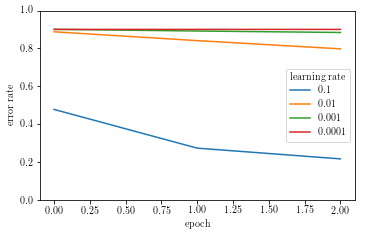

In [76]:
for learning_rate, error in error_per_learning_rate.items():
    plt.plot(error, label=learning_rate)
plt.legend(title='learning rate', loc='best')
plt.ylim((0, 1))
plt.xlabel('epoch')
plt.ylabel('error rate')

plt.savefig('../report/assets/error.pdf')
plt.show()

## Runtime CPU vs GPU

How does the number of parameters
change if you increase the number of filters? 

How does the runtime change? 

At last, run the same experiments again on a CPU, How does the plot change?

In [82]:
gpu_filters = [8, 16, 32, 64, 128, 256]
cpu_filters = [8, 16, 32, 64]

devices = device_lib.list_local_devices()
cpus = [d for d in devices if d.device_type == 'CPU']
gpus = [d for d in devices if d.device_type == 'GPU']

train_config = dict(max_epochs=3, batch_size=10000,
                    learning_rate=0.1, y_one_hot=True)

def check_time(filters, times):
    for n_filter in filters:
        print("USE #FILTER {}".format(n_filter))
        start = time.time()
        lenet = LeNet(init_stddev=0.1, n_filter=16)
        trace = lenet.train(X_train_subset, y_train_subset,
                            X_valid, y_valid,
                            **train_config)
        end = time.time()
        times.append(end - start)

USE CPU
USE #FILTER 8
... setup training
... starting training
epoch 1: loss 2.2315, train error 0.7855, valid error 0.7840
epoch 2: loss 2.1676, train error 0.6978, valid error 0.6940
epoch 3: loss 2.0811, train error 0.6213, valid error 0.6130
USE #FILTER 16
... setup training
... starting training
epoch 1: loss 2.2080, train error 0.7851, valid error 0.7743
epoch 2: loss 2.1150, train error 0.6714, valid error 0.6639
epoch 3: loss 1.9923, train error 0.5691, valid error 0.5622
USE #FILTER 32
... setup training
... starting training
epoch 1: loss 2.2634, train error 0.8344, valid error 0.8405
epoch 2: loss 2.1966, train error 0.7577, valid error 0.7608
epoch 3: loss 2.1103, train error 0.6672, valid error 0.6614
USE #FILTER 64
... setup training
... starting training
epoch 1: loss 2.2270, train error 0.8227, valid error 0.8132
epoch 2: loss 2.1450, train error 0.6773, valid error 0.6613
epoch 3: loss 2.0336, train error 0.5642, valid error 0.5491


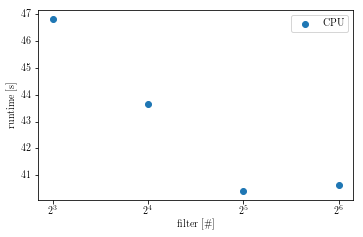

In [80]:
gpu_time = []
cpu_time = []

if len(cpus) > 0:
    print("USE CPU")
    with tf.device(cpus[0].name):
        check_time(cpu_filters, cpu_time)

if len(gpus) > 0:
    print("USE GPU")
    with tf.device(gpus[0].name):
        check_time(gpu_filters, gpu_time)

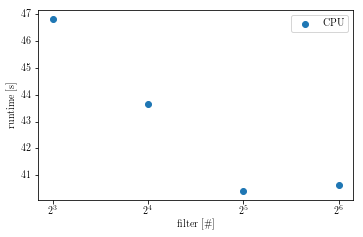

In [81]:
if len(cpus) > 0:
    plt.scatter(cpu_filters, cpu_time, label='CPU')

if len(gpus) > 0:
    plt.scatter(gpu_filters, gpu_time, label='GPU')
    
plt.legend(loc='best')
plt.xlabel('filter [\#]')
plt.xscale('log', basex=2)
plt.ylabel('runtime [s]')

plt.savefig('../report/assets/runtime.pdf')
plt.show()